In [1]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt

In [2]:
# 1. Daten laden
dateipfad = 'Artikelbewertung (1).xlsx'
df = pd.read_excel(dateipfad)
df['Bewertungstext'] = df['Bewertungstext'].fillna('').astype(str)

In [3]:
# 2. Multilinguales Sentiment-Modell laden
modell_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
tokenizer = AutoTokenizer.from_pretrained(modell_name)
model = AutoModelForSequenceClassification.from_pretrained(modell_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cpu


In [4]:
# 3. Sentiment-Analyse Funktion
def analysiere_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])[0]
        label = result['label'].lower()  # 'positive', 'neutral', 'negative'
        score = float(result['score'])
        return {'label': label, 'score': score}
    except Exception as e:
        return {'label': 'fehler', 'score': 0.0}

df['sentiment'] = df['Bewertungstext'].apply(analysiere_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: x['label'])
df['sentiment_score'] = df['sentiment'].apply(lambda x: x['score'])

def bewertung_to_sentiment(bewertung):
    try:
        if bewertung >= 4:
            return "positiv"
        elif bewertung == 3:
            return "neutral"
        elif bewertung < 3:
            return "negativ"
        else:
            return "unbekannt"
    except:
        return "unbekannt"

df['rating_sentiment'] = df['Bewertung'].apply(bewertung_to_sentiment)

In [5]:
# 4. Produktbezogene Analyse (wie bisher)
produkt_summary = []
for artikel, group in df.groupby('Artikel'):
    total = len(group)
    ai_pos = group[group['sentiment_label'] == 'positive']
    rating_pos = group[group['rating_sentiment'] == 'positiv']
    ai_happy_pct = round(100 * len(ai_pos) / total, 2) if total else 0
    rating_happy_pct = round(100 * len(rating_pos) / total, 2) if total else 0
    ort_punkt = round(group['Bewertung'].mean(), 2) if total else 0

    en_positiv = ""
    en_negativ = ""
    valid_scores = group.dropna(subset=['sentiment_score'])
    if not valid_scores.empty:
        best_row = valid_scores.loc[valid_scores['sentiment_score'].idxmax()]
        worst_row = valid_scores.loc[valid_scores['sentiment_score'].idxmin()]
        en_positiv = str(best_row['Bewertungstext'])
        en_negativ = str(worst_row['Bewertungstext'])

    produkt_summary.append({
        'Produkt': str(artikel),
        'Anzahl Bewertungen': total,
        'Zufriedenheit Kommentare (%)': ai_happy_pct,
        'Zufriedenheit Sterne (%)': rating_happy_pct,
        'Ø Bewertung': ort_punkt,
        'Positivster Kommentar': en_positiv,
        'Negativster Kommentar': en_negativ
    })

produkt_df = pd.DataFrame(produkt_summary)

In [6]:
# 5. GESAMTE Markt/Sammlung-Analyse (ALLES ZUSAMMEN)
gesamt_ai_anzahl = len(df[df['sentiment_label'] == 'positive'])
gesamt_user_anzahl = len(df[df['rating_sentiment'] == 'positiv'])
gesamt_anzahl = len(df)

gesamt_ai_glueck = round(100 * gesamt_ai_anzahl / gesamt_anzahl, 2) if gesamt_anzahl else 0
gesamt_user_glueck = round(100 * gesamt_user_anzahl / gesamt_anzahl, 2) if gesamt_anzahl else 0
gesamt_ø_bewertung = round(df['Bewertung'].mean(), 2) if gesamt_anzahl else 0

In [7]:
# 6. RANKINGS für Produkte (Top/Flop nach verschiedenen Metriken)
# Top Zufriedenheit Kommentare Ranking
ranking_ai = produkt_df.sort_values("Zufriedenheit Kommentare (%)", ascending=False).reset_index(drop=True)
# Top Zufriedenheit Sterne Ranking
ranking_user = produkt_df.sort_values("Zufriedenheit Sterne (%)", ascending=False).reset_index(drop=True)
# Top Ø Bewertung
ranking_bewertung = produkt_df.sort_values("Ø Bewertung", ascending=False).reset_index(drop=True)

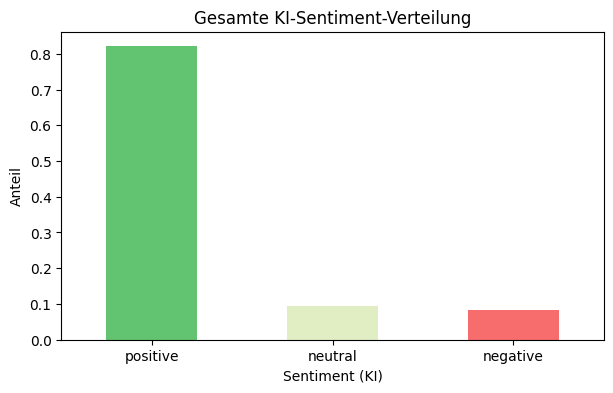

In [8]:
# 7. VISUALISIERUNG: Gesamtverteilung
plt.figure(figsize=(7, 4))
df['sentiment_label'].value_counts(normalize=True).plot(kind='bar', color=["#62c370", "#e1eec3", "#f76c6c"])
plt.title("Gesamte KI-Sentiment-Verteilung")
plt.xlabel("Sentiment (KI)")
plt.ylabel("Anteil")
plt.xticks(rotation=0)
plt.show()

In [9]:
df.to_pickle('alle_kommentare.pkl')
produkt_df.to_pickle('produkt_uebersicht.pkl')